# 0.0. IMPORTS

In [22]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import HTML
from IPython.display import Image 


## 0.1. Helper Functions

In [23]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [24]:
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [25]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# Merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [26]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
397243,53,6,2014-07-12,3802,410,1,0,0,0,a,c,30360.0,9.0,2013.0,0,NaN,NaN,NaN


# 1.0. PASSO 01 - DESCRICAO DOS DADOS

## 1.1. Rename Columns

In [27]:
# Copia do Dataframe
df1 = df_raw.copy()

In [28]:
# Nome antigo das colunas
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
            'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
            'CompetitionDistance', 'CompetitionOpenSinceMonth',
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
            'Promo2SinceYear', 'PromoInterval']

# Função para ajusar o nome das colunas
snakecase = lambda x: inflection.underscore( x )
cols_new = list(map(snakecase, cols_old))

# Renomear as colunas do Dataframe
df1.columns = cols_new


## 1.2. Data Dimensions

In [29]:
print('Numer of Rows: {}'.format(df1.shape[0]))
print('Numer of Columns: {}'.format(df1.shape[1]))

Numer of Rows: 1017209
Numer of Columns: 18


## 1.3. Data Types

In [30]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [31]:
# Verificar quantas features temos com dados NA
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

Tratamento dos dados Faltantes
- Avaliar cada um dos casos e propor uma melhor solução para o tratamento desses dados:
    - competition_distance - distance in meters to the nearest competitor store
    - competition_open_since_month-  gives the approximate month of the time the nearest competitor was opened
    - competition_open_since_year -  gives the approximate year of the time the nearest competitor was opened
    - promo2_since_week - describes calendar week when the store started participating in Promo2
    - promo2_since_year - describes the year when the store started participating in Promo2
    - promo_interval - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g


Possibilidades para o tratamento dos NA
 - 1. Excluir os dados com NA (vantagem é ser muito rápido para executar, desvantagem perde-se muita informação)
 - 2. Usar algoritmos de Machine Learning para fazer a substituição conforme o comportamento da coluna (aplicar média, ou mediana, aplicar o valor conforme a clusterização)
 - 3. Pensar como o negócio, refletir o porque esse NA foi gerado e seguir tratando cada um dos casos.

#### competition_distance

**Assumptions**:
 - A coluna está com NA devido não ter competir próximo ou se existe competidor ele está muito distante dessa loja.
 - Realizar a inclusão de um valor que representa essa inexistência ou irrelevância por estar muito distante

In [32]:
# Verificar o maior valor referente a essa feature
df1['competition_distance'].max()

75860.0

In [33]:
# Realizar o input do valor de 200000 nos valores faltantes
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 2000000.0 if math.isnan(x) else x )

#### competition_open_since_month

**Assumptions**:
 - Iremos inferir que essa coluna possui dados faltantes devido a loja não temos um competidor mais próximo, a loja tem um competidor mais próximo, mas não sabe quando foi aberto, ou porque esse competidor abriu muito antes da loja ser aberta ou o competidor abriu depois e esqueceram de anotar
 - Seguiremos com o processo de copiar a data da venda dessa linha especifica que possui o dado NA, claro extrair o mês dessa data de venda.


In [34]:
df1['competition_open_since_month'] = df1.apply(
                                                lambda x: x['date'].month if math.isnan(x['competition_open_since_month'])
                                                else x['competition_open_since_month'], axis=1)

#### competition_open_since_year

**Assumptions**:
 - Iremos inferir que essa coluna possui dados faltantes devido a loja não temos um competidor mais próximo, a loja tem um competidor mais próximo, mas não sabe quando foi aberto, ou porque esse competidor abriu muito antes da loja ser aberta ou o competidor abriu depois e esqueceram de anotar
 - Seguiremos com o processo de copiar a data da venda dessa linha especifica que possui o dado NA, claro extrair o ano dessa data de venda.


In [35]:
df1['competition_open_since_year'] = df1.apply(
                                                lambda x: x['date'].year if math.isnan(x['competition_open_since_year'])
                                                else x['competition_open_since_year'], axis=1)

#### promo2_since_week

**Assumptions**:
 - Iremos inferir que essa coluna possui dados faltantes devido a loja em questão não decidiu participar dessa promoção.
 - Seguiremos a mesma estratégia adotada anteriormente criando uma cópia da data da venda dessa linha especifica que possui o dado NA, claro extrair a semana dessa data de venda.

In [36]:
df1['promo2_since_week'] = df1.apply(
                                    lambda x: x['date'].week if math.isnan(x['promo2_since_week'])
                                    else x['promo2_since_week'], axis=1)

#### promo2_since_year

**Assumptions**:
 - Iremos inferir que essa coluna possui dados faltantes devido a loja em questão não decidiu participar dessa promoção.
 - Seguiremos a mesma estratégia adotada anteriormente criando uma cópia da data da venda dessa linha especifica que possui o dado NA, claro extrair o ano dessa data de venda.

In [37]:
df1['promo2_since_year'] = df1.apply(
                                    lambda x: x['date'].year if math.isnan(x['promo2_since_year'])
                                    else x['promo2_since_year'], axis=1)

#### promo_interval

**Assumptions**:
 - Seguiremos a mesma estratégia adotada anteriormente.
 - Realizar um split dessa coluna e criar uma lista e verificar se o mês dessa data estiver dentro da lista a promo2 estava ativa.

In [38]:
# Verificação dos dados únicos da coluna promo_interval
df1['promo_interval'].unique()

array([nan, 'Jan,Apr,Jul,Oct', 'Feb,May,Aug,Nov', 'Mar,Jun,Sept,Dec'],
      dtype=object)

In [39]:
# Criar um dicionário com o número do mês e sua abreviação
month_map = {
1: 'Jan',
2: 'Feb',
3: 'Mar',
4: 'Apr',
5: 'May',
6: 'Jun',
7: 'Jul',
8: 'Aug',
9: 'Sept',
10: 'Oct',
11: 'Nov',
12: 'Dec'
}

In [40]:
# Preencher os valores NA da coluna promo_interval com Zero
df1['promo_interval'].fillna(0, inplace = True)

# Criar uma coluna month_map
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [41]:
# Verificar o resultado parcial, se a coluna foi criada seguinte o mapeamento do mês de acordo com o dicionário criado
df1.sample(5).T

,26866,172371,429960,787943,362157
store,107,662,356,424,582
day_of_week,2,5,3,4,2
date,2015-07-07 00:00:00,2015-02-27 00:00:00,2014-06-11 00:00:00,2013-07-25 00:00:00,2014-08-19 00:00:00
sales,6749,7949,4653,4811,8802
customers,910,749,337,625,983
open,1,1,1,1,1
promo,0,0,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,1,1,1
store_type,a,d,d,d,a


In [42]:
# Realizar um split baseado na virgula (',') nesse array da coluna promo_interval
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [43]:
# Verificar o resultado
df1.sample(5).T

,376327,24808,603919,881265,403315
store,761,279,375,86,602
day_of_week,1,4,1,4,7
date,2014-08-04 00:00:00,2015-07-09 00:00:00,2014-01-06 00:00:00,2013-05-02 00:00:00,2014-07-06 00:00:00
sales,12207,6990,0,6717,0
customers,1273,558,0,828,0
open,1,1,0,1,0
promo,1,0,1,1,0
state_holiday,0,0,a,0,0
school_holiday,1,0,0,0,0
store_type,a,d,a,a,a


## 1.6. Change Types

In [44]:
# Transformar variáveis float para int
# Não faz sentido essas variáveis estarem como float pois são int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype('int64')
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype('int64')
df1['promo2_since_week'] = df1['promo2_since_week'].astype('int64')
df1['promo2_since_year'] = df1['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistical

In [45]:
# Separar em variáveis numéricas e variáveis categoricas
num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 1.7.1. Numerical Attributes

In [46]:
# Central Tendency
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenat
m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6]).T.reset_index()

# Nomear as Colunas
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,2000000.0,1999980.0,10610.588099,2330.0,101810.649100,19.378002,375.644405
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


Text(0, 0.5, 'Densidade')

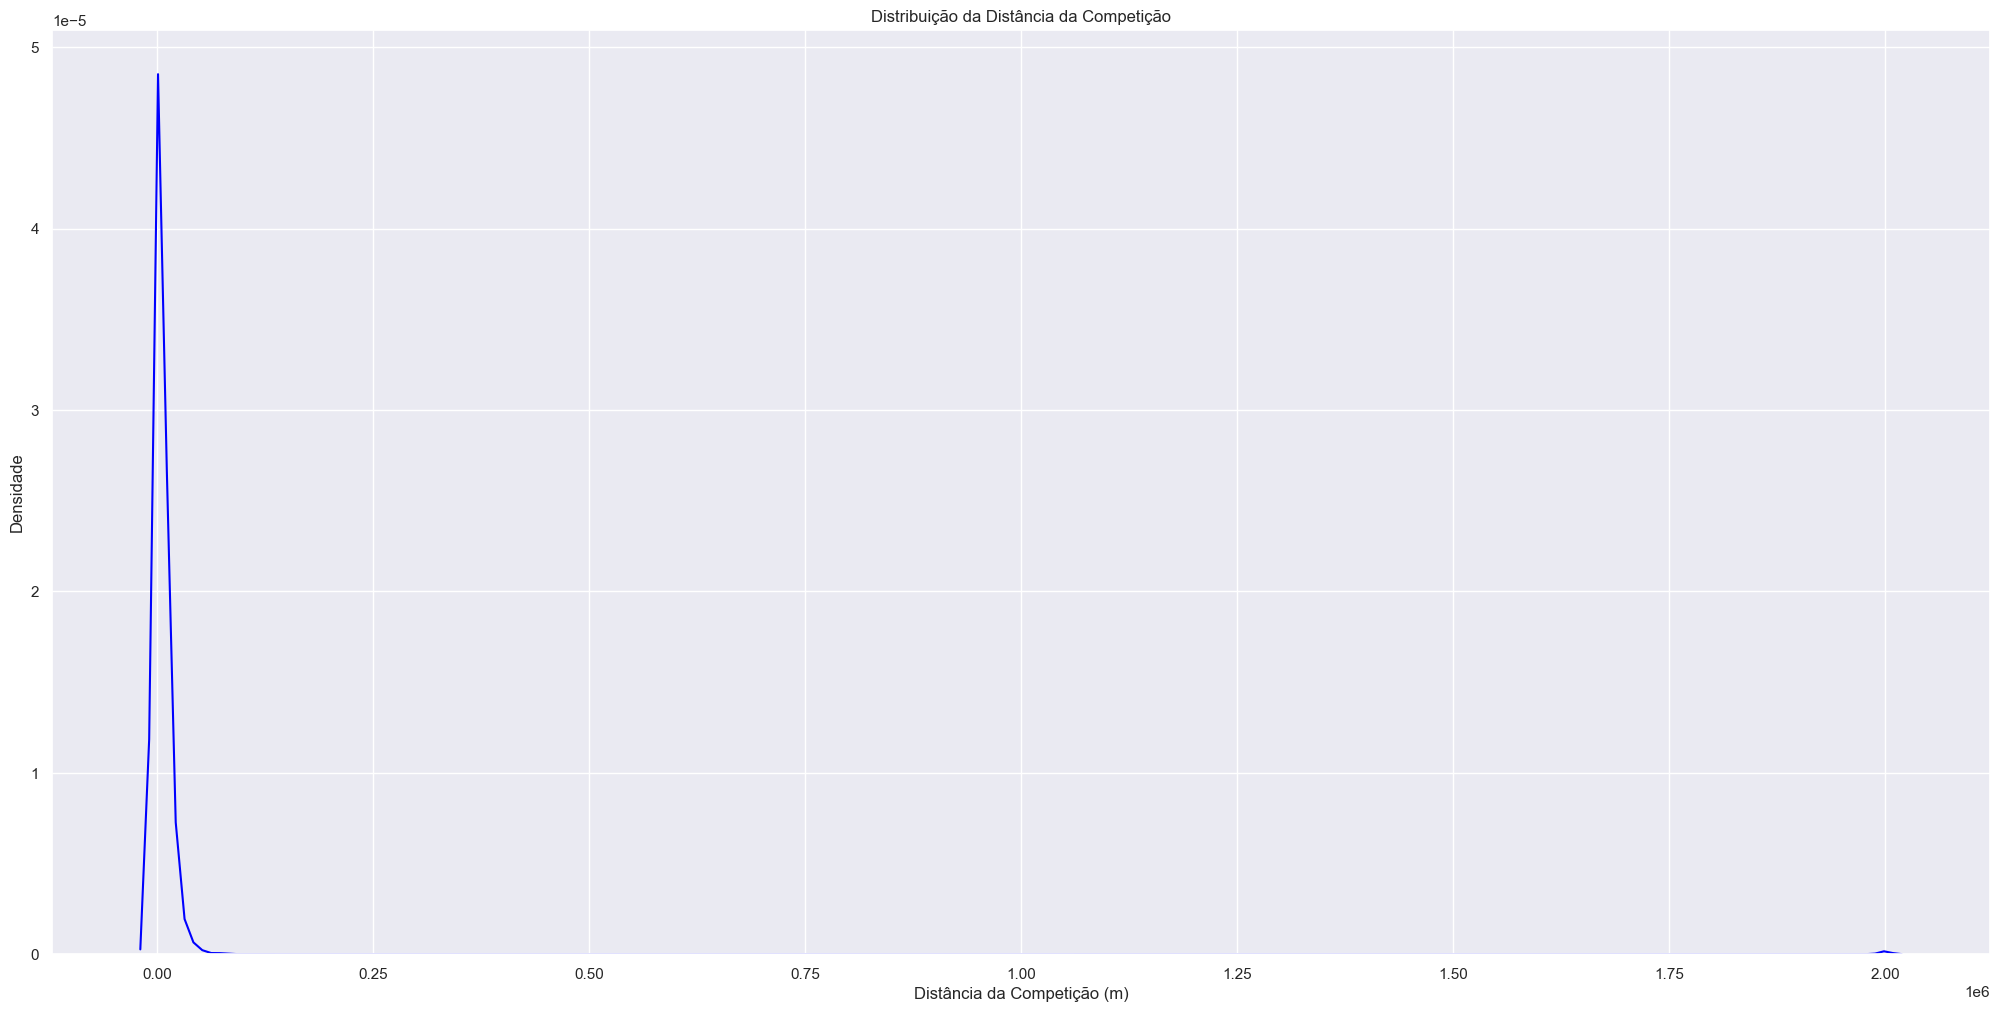

In [47]:
sns.kdeplot(df1['competition_distance'], color='blue')
plt.title('Distribuição da Distância da Competição')
plt.xlabel('Distância da Competição (m)')
plt.ylabel('Densidade')

### 1.7.2. Categorical Attriburtes

In [48]:
# Identificar a quantidade de variaveis
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

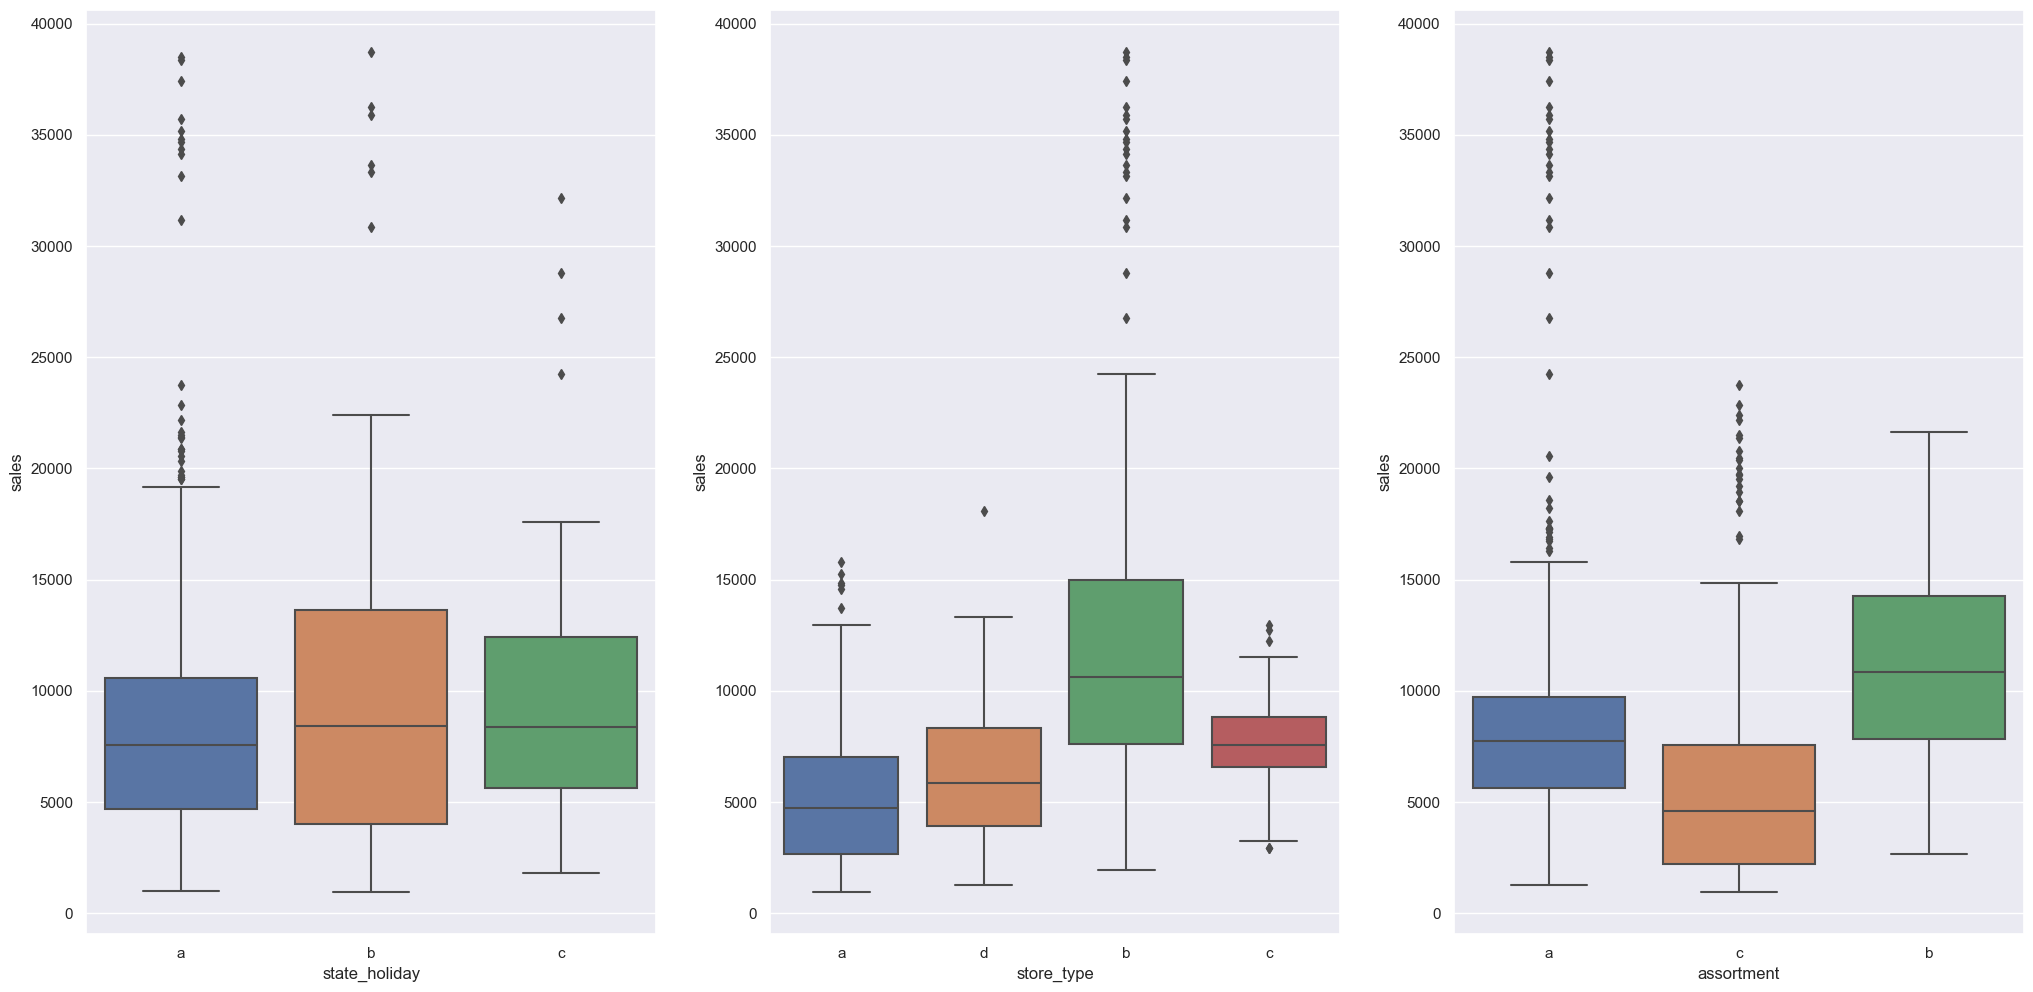

In [49]:
# Necessidade filtrar as datas retirando os dias que as lojas estão fechadas e vendas maiores que zero
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] >0 )]

# Plotar um box-plot ao lado do outro (plt.subplot( linhas, colunas, posição))
plt.subplot(1, 3, 1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
sns.boxplot(x='assortment', y='sales', data=aux1)


# 2.0. PASSO 02 - FEATURE ENGINEERING

In [50]:
df2 = df1.copy()

## 2.1. MINDMAP HYPOTHESES

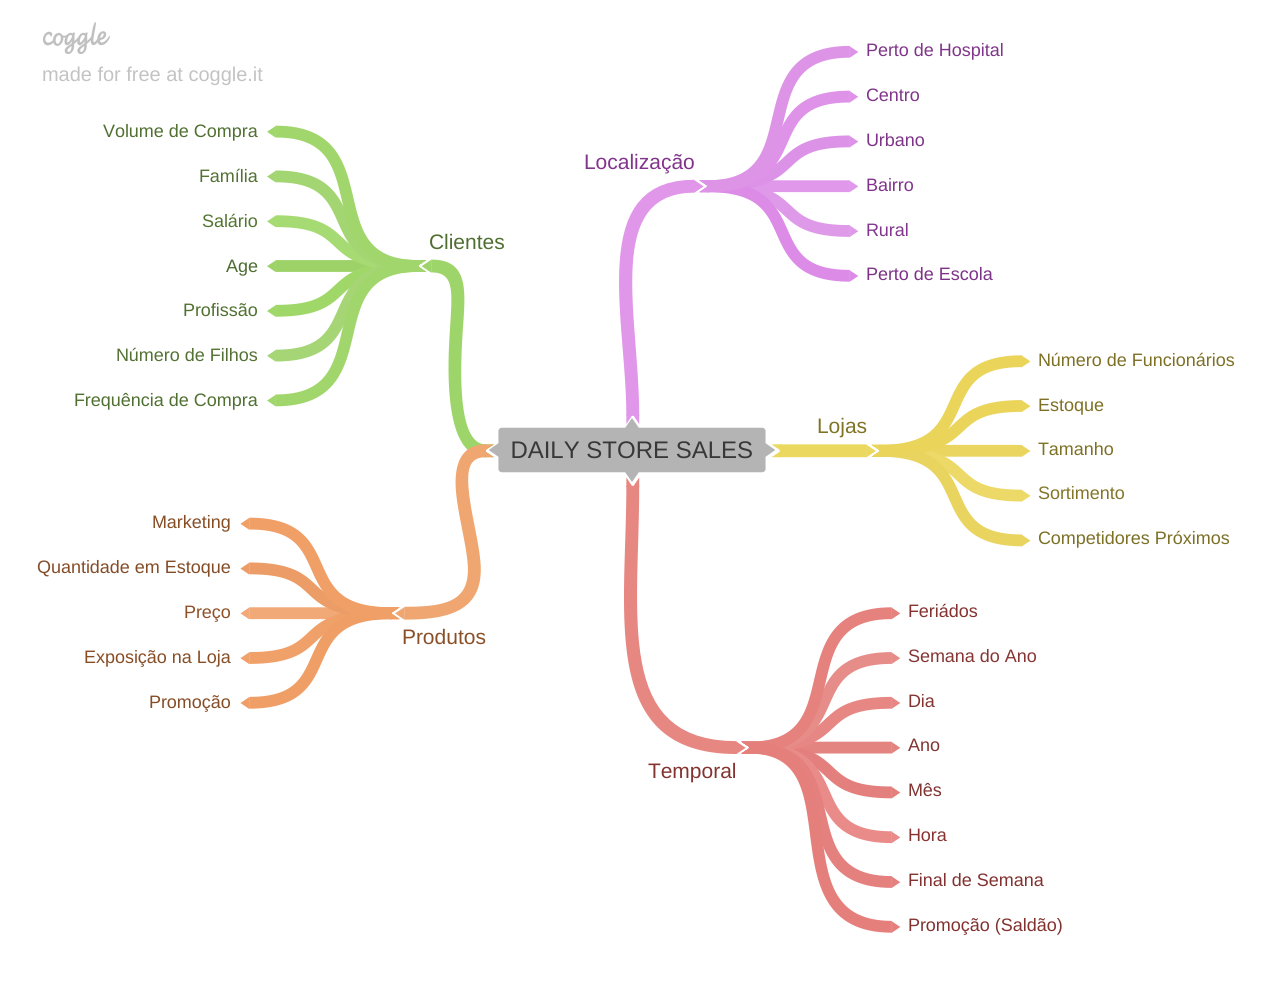

In [51]:
# Classe image para importar o mapa mental
Image('img/MindMapHypotheses.png')

## 2.2. HYPOTHESES CREATION

### 2.1.1. Stores Hypothesis

**1.** Lojas com número maior de funcionários deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimentos deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores à mais tempo deveriam vendem mais.

### 2.1.2. Product Hypothesis

**1.** Lojas que investem mais em Marketing deveriam vender mais.

**2.** Lojas com maior exposição de produto deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**5.** Lojas com promoções mais agressivas ( descontos maiores ), deveriam vender mais.

**6.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**7.** Lojas com mais dias de promoção deveriam vender mais.

**8.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3. Temporal Hypothesis

**1.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. FINAL LIST HYPOTHESES

**1.** Lojas com maior sortimentos deveriam vender mais.

**2.** Lojas com competidores mais próximos deveriam vender menos.

**3.** Lojas com competidores à mais tempo deveriam vendem mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo dos anos.

**9.** Lojas deveriam vender mais no segundo semestre do ano.

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos aos finais de semana.

**12.** Lojas deveriam vender menos durante os feriados escolares.

## 2.4. FEATURE ENGINEERING

In [64]:
# year
# transforma em datatime (dt) e usa o metodo .year
df2['year'] = df2['date'].dt.year

# month
# transforma em datatime (dt) e usa o metodo .month
df2['month'] = df2['date'].dt.month

# day
# transforma em datatime (dt) e usa o metodo .day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
# cria coluna competition_since, fazendo a união atravez do método datetime.datetime
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year = x['competition_open_since_year'] , month= x['competition_open_since_month'], day=1), axis = 1)
#faz a diferença das colunas date e competition_since - para obter o tempo de promoção em mes
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
# Realizar o join nos caracteres, importante que as duas veriáveis sejam strings converter com .astype(str)
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
# Converter para uma data com o método .strptime(), somar -1 e colocar o formato de resultado '%Y-%W-%w' (Ano - Semana do Ano - Semana (dom à dom))
# Utilizar o método time delta para substituir 7 dias dessa nova data. Não é necessário usar o axis=1 por ser aplicado somente em uma coluna
df2['promo_since']= df2['promo_since'].apply(lambda x: datetime.datetime.strptime( x + '-1', '%Y-%W-%w') - datetime.timedelta(days = 7))
# Subtrair as datas
df2['promo_time_week'] = ((df2['date'] - df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
# Incluir os níveis
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
# Substituir conforme os significados dos feriados
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [65]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a
